## Anastasia Horne, 10867499

# 1D Conduction in Radial Coordinates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import *

## . . For animation
from matplotlib import animation
from IPython.display import HTML,Image
from time import time

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve


# Steady State Analytical Solution

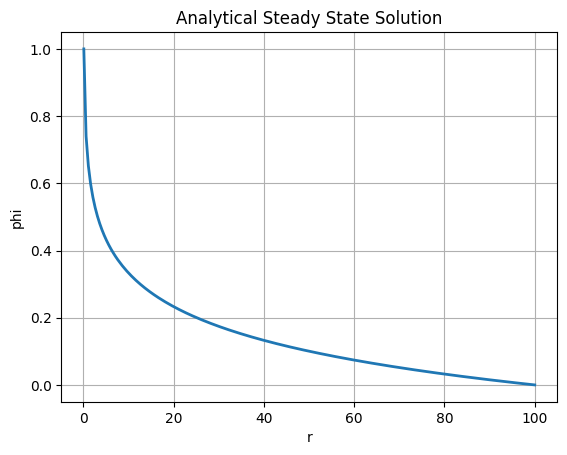

In [2]:
#Analytical Solution (work in report)
nr=200
r= np.linspace(0.1, 100, nr)
analyt_soln= (1/np.log(0.001))*np.log(r) - (np.log(100)/np.log(0.001))

plt.plot(r, analyt_soln, linewidth=2)
plt.title("Analytical Steady State Solution")
plt.xlabel("r")
plt.ylabel("phi")
plt.grid(True)
# plt.savefig("Analytical_steady_state.png")
# print(analyt_soln)

# 1D Radial Solver

Steady state reached at t = 4189.7
The total execution time for python: 50.80167770385742 s


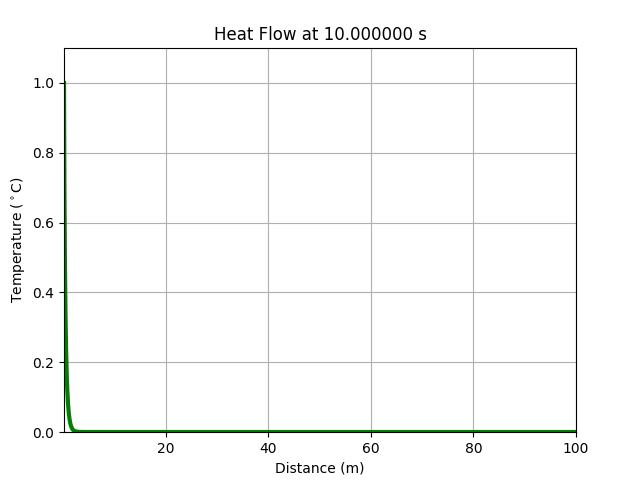

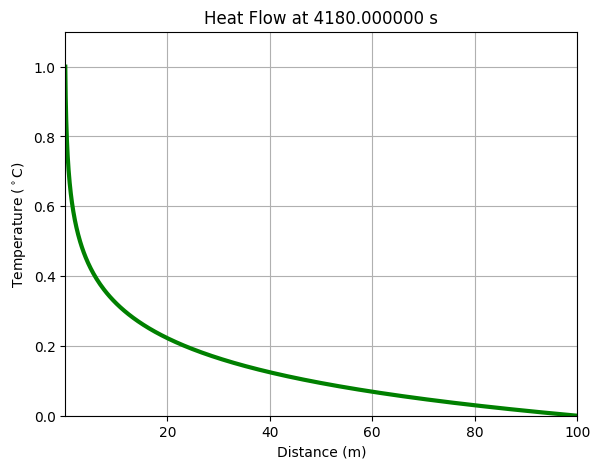

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image

def TDMAsolver(a, b, c, d):
    nf = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for it in range(1, nf):
        mc = ac[it]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1]
        dc[it] = dc[it] - mc*dc[it-1]
    xc = bc
    xc[-1] = dc[-1]/bc[-1]
    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]
    return xc

def nonuni_grid(r_min, r_max, n_points):
    return np.geomspace(r_min, r_max, n_points)

def Diffusion_1D_Radial(U, K, r, dt):
    n = len(U)
    dr = np.diff(r)  # Non-uniform grid spacing
    r_mid = (r[1:] + r[:-1])/2  # Midpoints for flux calculation

    # Set up coefficients for tridiagonal matrix
    a = np.zeros(n-2)
    b = np.zeros(n-2)
    c = np.zeros(n-2)
    d = np.zeros(n-2) #phi^n_i

    for i in range(1, n-1):
        dr_minus = r[i] - r[i-1]
        dr_plus = r[i+1] - r[i]

        # Coefficients based on non-uniform grid
        a[i-1] = -K*dt/(dr_minus * r[i]) * r_mid[i-1]
        c[i-1] = -K*dt/(dr_plus * r[i]) * r_mid[i]
        b[i-1] = 1 - (a[i-1] + c[i-1])
        d[i-1] = U[i]

    #apply BC
    d[0] += -a[0]*U[0]    #LB
    d[-1] += -c[-1]*U[-1] #RB

    #solve tridiag system
    tmp = TDMAsolver(a, b, c, d)
    U[1:n-1] = tmp

    return U

def steady_state(old_U, new_U, tolerance=1e-4):
    return np.sum(np.abs(new_U - old_U)) < tolerance

#parameters
K = 1.0  #diffusion coefficient (was not stated in problem so I chose 1)
r_min, r_max = 0.1, 100.0
nr = 200  #num points
max_time = 200000  #max time steps
dt = .1

#non-uniform grid
r = nonuni_grid(r_min, r_max, nr)

#solution array
U = np.zeros(nr)
U[0] = 1.0  #LB
U[-1] = 0.0  #RB

#run disc. through time
solutions = np.zeros((nr,max_time))
old_U = U.copy()
start=time()
for t in range(max_time):
    U = Diffusion_1D_Radial(U.copy(), K, r, dt)

    #apply BC
    U[0] = 1.0
    U[-1] = 0.0

    solutions[:,t]=U

    #check for steady state
    if t > 0 and steady_state(old_U, U):
        t_final= t*dt
        nt=t+1 #num pts in solutions
        print("Steady state reached at t =", t*dt)
        break #end diffusion

    old_U = U.copy()
end=time()
print("The total execution time for python:", end-start, "s")

#crop solutions
solutions2= solutions[:,0:nt]

def diffusion_1D_animate(i):
    global k
    ax1.clear()
    ax1.plot(r,solutions2[:,k],'g', linewidth=3)
    ax1.grid(True)
    ax1.set_xlim([r_min,r_max])
    ax1.set_ylim([0,1.1])
    ax1.set(xlabel='Distance (m)',ylabel='Temperature ($^\circ$C)')
    ax1.set_title('Heat Flow at %f s'%(k*dt))
    k += kskip

## . . Animate solution
k = 0
kskip = 100

## . . Set up movie
fig5,ax1 = plt.subplots(1)
fig5.subplots_adjust(0.1,0.1,0.9,0.9)
fig5.set_dpi(100)

## . . Call the animator.
ani_filename = 'Ex5.gif'
anim5 = animation.FuncAnimation(fig5,diffusion_1D_animate,frames=int((nt-kskip)/kskip),interval=100)
anim5.save(ani_filename)

Image(open(ani_filename,'rb').read())

# C - Implementation

In [4]:
%%writefile 1D_Radial_c.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>
#include <string.h>

#define MAX_TIME 200000
#define NR 200
#define R_MIN 0.1
#define R_MAX 100.0
#define DT 0.1
#define K 1.0
#define TOLERANCE 1e-4

// Function to create non-uniform grid using geometric progression
void nonuni_grid(double* r, int n_points, double r_min, double r_max) {
    double ratio = pow(r_max/r_min, 1.0/(n_points-1));
    for(int i = 0; i < n_points; i++) {
        r[i] = r_min * pow(ratio, i);
    }
}

// TDMA solver implementation
void TDMAsolver(double* a, double* b, double* c, double* d, double* x, int n) {
    double* c_star = (double*)malloc(n * sizeof(double));
    double* d_star = (double*)malloc(n * sizeof(double));

    // Forward sweep
    c_star[0] = c[0] / b[0];
    d_star[0] = d[0] / b[0];

    for(int i = 1; i < n; i++) {
        double m = 1.0 / (b[i] - a[i] * c_star[i-1]);
        c_star[i] = c[i] * m;
        d_star[i] = (d[i] - a[i] * d_star[i-1]) * m;
    }

    // Back substitution
    x[n-1] = d_star[n-1];
    for(int i = n-2; i >= 0; i--) {
        x[i] = d_star[i] - c_star[i] * x[i+1];
    }

    free(c_star);
    free(d_star);
}

// Diffusion solver for one time step
void Diffusion_1D_Radial(double* U, double* r, int n, double dt) {
    double* a = (double*)malloc((n-2) * sizeof(double));
    double* b = (double*)malloc((n-2) * sizeof(double));
    double* c = (double*)malloc((n-2) * sizeof(double));
    double* d = (double*)malloc((n-2) * sizeof(double));
    double* r_mid = (double*)malloc((n-1) * sizeof(double));

    // Calculate midpoints
    for(int i = 0; i < n-1; i++) {
        r_mid[i] = (r[i+1] + r[i])/2;
    }

    // Set up coefficients
    for(int i = 1; i < n-1; i++) {
        double dr_minus = r[i] - r[i-1];
        double dr_plus = r[i+1] - r[i];

        a[i-1] = -K*dt/(dr_minus * r[i]) * r_mid[i-1];
        c[i-1] = -K*dt/(dr_plus * r[i]) * r_mid[i];
        b[i-1] = 1 - (a[i-1] + c[i-1]);
        d[i-1] = U[i];
    }

    // Apply boundary conditions
    d[0] += -a[0]*U[0];
    d[n-3] += -c[n-3]*U[n-1];

    // Solve system
    double* solution = (double*)malloc((n-2) * sizeof(double));
    TDMAsolver(a, b, c, d, solution, n-2);

    // Update U
    for(int i = 1; i < n-1; i++) {
        U[i] = solution[i-1];
    }

    free(a);
    free(b);
    free(c);
    free(d);
    free(r_mid);
    free(solution);
}

// Check for steady state
int steady_state(double* old_U, double* new_U, int n) {
    double sum = 0.0;
    for(int i = 0; i < n; i++) {
        sum += fabs(new_U[i] - old_U[i]);
    }
    return sum < TOLERANCE;
}

int main() {

    // Initialize arrays
    double* r = (double*)malloc(NR * sizeof(double));
    double* U = (double*)calloc(NR, sizeof(double));
    double* old_U = (double*)malloc(NR * sizeof(double));

    // Create grid
    nonuni_grid(r, NR, R_MIN, R_MAX);

    // Initial conditions
    U[0] = 1.0;  // Left boundary
    U[NR-1] = 0.0;  // Right boundary

    // Open output file
    FILE* fp = fopen("diffusion_solution.txt", "w");
    if(!fp) {
        printf("Error opening file!\n");
        return 1;
    }

    // Write initial grid points
    fprintf(fp, "# r coordinates\n");
    for(int i = 0; i < NR; i++) {
        fprintf(fp, "%lf ", r[i]);
    }
    fprintf(fp, "\n\n# Solutions at each time step\n");

    // Time stepping
    clock_t start = clock();
    int t_final = 0;
    for(int t = 0; t < MAX_TIME; t++) {
        // Save current solution
        memcpy(old_U, U, NR * sizeof(double));

        // Write current solution to file
        for(int i = 0; i < NR; i++) {
            fprintf(fp, "%lf ", U[i]);
        }
        fprintf(fp, "\n");

        // Solve for next time step
        Diffusion_1D_Radial(U, r, NR, DT);

        // Apply boundary conditions
        U[0] = 1.0;
        U[NR-1] = 0.0;

        // Check for steady state
        if(t > 0 && steady_state(old_U, U, NR)) {
            t_final = t;
            printf("Steady state reached at t = %f\n", t*DT);
            break;
        }
    }

    clock_t end = clock();
    double time_spent = (double)(end - start) / CLOCKS_PER_SEC;
    printf("The total execution time for C: %f s\n", time_spent);

    // Clean up
    fclose(fp);
    free(r);
    free(U);
    free(old_U);

    return 0;
}

Overwriting 1D_Radial_c.c


In [5]:
%%shell
gcc -o 1D_Radial_c 1D_Radial_c.c -lm
./1D_Radial_c

Steady state reached at t = 4189.700000
The total execution time for C: 4.269498 s


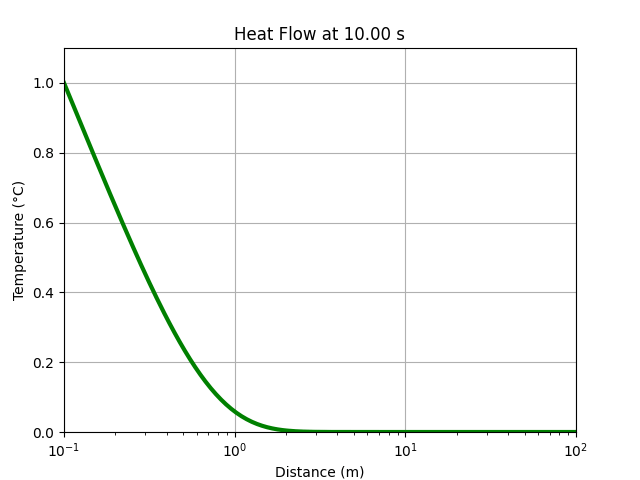

Total number of time steps: 41898
Final time: 4189.70 s


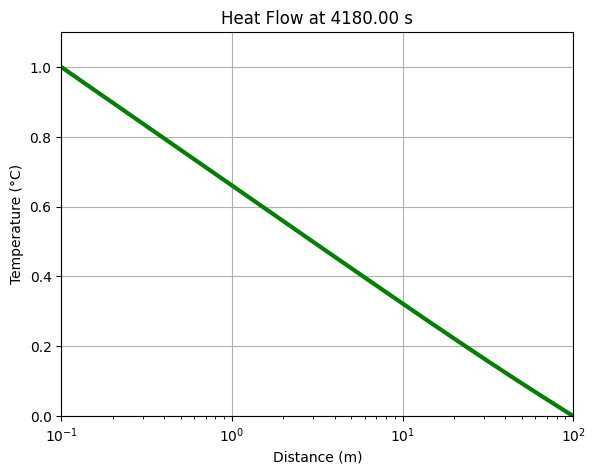

In [6]:
# check to make sure C code is right (this was also created using AI)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image

# Read the solution file
with open('diffusion_solution.txt', 'r') as f:
    # Skip the comment line and read r coordinates
    _ = f.readline()  # skip comment
    r = np.array([float(x) for x in f.readline().strip().split()])

    # Skip empty line and comment
    _ = f.readline()
    _ = f.readline()

    # Read all solutions
    solutions = []
    for line in f:
        solution = np.array([float(x) for x in line.strip().split()])
        solutions.append(solution)

# Convert solutions to numpy array
solutions = np.array(solutions)

# Animation parameters
dt = 0.1  # same as in C program
kskip = 100  # same as original
k = 0

# Set up the figure
fig, ax = plt.subplots(1)
fig.subplots_adjust(0.1, 0.1, 0.9, 0.9)
fig.set_dpi(100)

def update(frame):
    global k
    ax.clear()
    ax.plot(r, solutions[k], 'g', linewidth=3)
    ax.grid(True)
    ax.set_xlim([min(r), max(r)])
    ax.set_ylim([0, 1.1])
    ax.set_xscale('log')  # Using log scale for better visualization
    ax.set(xlabel='Distance (m)', ylabel='Temperature (°C)')
    ax.set_title(f'Heat Flow at {k*dt:.2f} s')
    k += kskip

# Create animation
anim = animation.FuncAnimation(
    fig,
    update,
    frames=int((len(solutions)-kskip)/kskip),
    interval=100
)

# Save animation
ani_filename = 'diffusion_animation.gif'
anim.save(ani_filename)

# Display animation (if in Jupyter notebook)
try:
    display(Image(open(ani_filename,'rb').read()))
except:
    print(f"Animation saved as {ani_filename}")

print(f"Total number of time steps: {len(solutions)}")
print(f"Final time: {(len(solutions)-1)*dt:.2f} s")